# Gradient-free Global Maximum Likelihood Finding: Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances, and symmetries in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS uses slice sampling as a gradient-free way to sample from hard-likelihood constraints, starting from small likelihoods and strictly increasing towards a maximum likelihood. This actually means that JAXNS is performing global maximisation of the likelihood. The prior can be seen as a measure which guides where JAXNS looks first. An attractive idea is to think about the prior as a guide for efficient global maximisation with JAXNS, but that's for another tutorial ;).

## Overview

In this tutorial we'll cover:
1. How to build a JAXNS model of a neural network using [Haiku](https://github.com/deepmind/dm-haiku)
2. How to do global likelihood maximisation with JAXNS

In [1]:
try:
    import haiku as hk
except ImportError:
    raise ImportError("You must `pip install dm-haiku` first.")

try:
    from sklearn.metrics import roc_curve
except:
    raise ImportError("You must `pip install scikit-learn`")

from jax import numpy as jnp, random, vmap
import jax
from jax.flatten_util import ravel_pytree

from jaxns.prior_transforms import UniformPrior, PriorChain
from jaxns import GlobalOptimiser
from jax.scipy.optimize import minimize
from itertools import product
import pylab as plt

# for parallel sampling
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Generate data

def xor_reduce(x):
    """
    Computes the XOR reduction on a sequence of bits.

    Examples:
        100 -> xor(xor(1,0),0) = 1
        001 -> xor(xor(0,0),1) = 1
        110 -> xor(xor(1,1),0) = 0
        011 -> xor(xor(0,1),1) = 0

    Args:
        x: boolean vector of bits.

    Returns:
        bool, scalar
    """
    output = x[0]
    for i in range(1, x.shape[-1]):
        output = jnp.logical_xor(output, x[i])
    return output


num_variables = 8
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))#N,2
y = vmap(xor_reduce)(x)[:, None]#N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x,y):
    print(f"{input} -> {output}")


INFO[2022-04-08 18:12:53,328]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-04-08 18:12:53,329]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-04-08 18:12:53,329]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-04-08 18:12:53,330]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Data:
[1. 1. 1. 1. 1. 1. 1. 1.] -> [False]
[1. 1. 1. 1. 1. 1. 1. 0.] -> [ True]
[1. 1. 1. 1. 1. 1. 0. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 0. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 0. 1. 1. 0.] -> [False]
[1. 1. 1. 1. 0. 1. 0. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1. 1.] -> [False]
[1. 1. 1. 1. 0. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 0. 1. 1. 1. 0.] -> [False]
[1. 1. 1. 0. 1. 1. 0. 1.] -> [False]
[1. 1. 1. 0. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 1. 1.] -> [False]
[1. 1. 1. 0. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 0. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 0. 1. 0. 0. 0.] -> [False]
[1. 1. 1. 0. 0. 1. 1. 1.] -> [False]
[1. 1. 1. 0. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 0. 0. 1. 0. 1.] -> [ T

In [3]:
# Define the likelihood, using Haiku as our framework for neural networks

def model(x, is_training=False):
    mlp1 = hk.Sequential([hk.Linear(3),
                         jax.nn.sigmoid,
                          hk.Linear(1)])

    return mlp1(x)

model = hk.without_apply_rng(hk.transform(model))
# We must call the model once to get the params shape and type as a big pytree
# We then use ravel_pytree to flatten and get the unflatten function.
init_params = model.init(random.PRNGKey(2345), x)
init_params_flat, unravel_func = ravel_pytree(init_params)
n_dims = init_params_flat.size
print("Number of parameters:", n_dims)

def softplus(x):
    return jnp.log1p(jnp.exp(x))

def log_likelihood(params):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    log_prob0, log_prob1 = -softplus(logits), -softplus(-logits)
    #log(p) * y + log(1-p) * (1-y)
    log_prob = jnp.mean(jnp.where(y, log_prob1, log_prob0))
    return jnp.asarray(log_prob, jnp.float64)


Number of parameters: 31


In [4]:
# Let us compare the results of nested sampling to optimisation done with BFGS
num_random_init = 100
init_keys = random.split(random.PRNGKey(42), num_random_init)
params_bfgs = vmap(lambda key: minimize(lambda p: -log_likelihood(p),
                   random.normal(key, shape=(n_dims,)),
                   method='BFGS').x)(init_keys)
log_L_bfgs = vmap(log_likelihood)(params_bfgs)
idx_max = jnp.argmax(log_L_bfgs)
log_L_bfgs_max = log_L_bfgs[idx_max]
params_bfgs_max = params_bfgs[idx_max]
print(f"BFGS maximum likelihood solution of {num_random_init} tries: log(L) = {log_L_bfgs_max}")

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2565: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


BFGS maximum likelihood solution of 100 tries: log(L) = -0.30103886127471924


In [15]:
# Build the model

with PriorChain() as prior_chain:
    # we'll effectively place no prior on the parameters, other than requiring them to be within [-10,10]
    UniformPrior('params', -10.*jnp.ones(n_dims), 10.*jnp.ones(n_dims))

# We'll do some strange things here.
# num_slices -> low: We'll make the sampler do very few slices. This will lead to large correlation between samples, and poor estimate of the evidence.
# This is alright, because we'll be looking for the maximum likelihood solution.
go = GlobalOptimiser(loglikelihood=log_likelihood, prior_chain=prior_chain,
                   samples_per_step=prior_chain.U_ndims*10)


In [6]:
# Let's test the model with a small sanity check.
prior_chain.test_prior(random.PRNGKey(42), 10, log_likelihood)

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2565: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")
INFO[2022-04-08 18:13:12,310]: Log-likelihood: -8.569480895996094
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2565: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.

In [19]:
results, state = go(random.PRNGKey(42),
             termination_frac_likelihood_improvement=1e-3,
             termination_patience=3,
             termination_max_num_likelihood_evaluations=20e6, return_state=True)

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2565: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


In [20]:
# The maximum likelihood solution from nested sampling
params_max = results.sample_L_max['params']
log_L_max = results.log_L_max
print("log L_max(L)", log_L_max)
go.summary(results)

log L_max(L) -0.3232653


# Let's try to refine this

In [23]:
results, state = go(random.PRNGKey(42),
             termination_frac_likelihood_improvement=1e-3,
             termination_patience=3,
             termination_max_num_likelihood_evaluations=20e6,
             refine_state=state, return_state=True)

In [29]:
# The maximum likelihood solution from nested sampling
params_max = results.sample_L_max['params']
log_L_max = results.log_L_max
print("log L_max(L)", log_L_max)
go.summary(results)

log L_max(L) -0.30872047
--------
Termination Conditions:
Small enough likelihood change with patience
--------
# likelihood evals: 15391083
# samples: 21993
# likelihood evals / sample: 699.8
--------
Maximum logL=-0.31
--------
params[#]: max(L) est.
params[0]: 4.1
params[1]: 2.9
params[2]: 9.5
params[3]: 9.72
params[4]: -8.58
params[5]: 9.23
params[6]: 8.2
params[7]: -9.5
params[8]: 9.7
params[9]: 9.7
params[10]: -9.9
params[11]: 9.2
params[12]: -9.5
params[13]: 9.6
params[14]: -8.5
params[15]: -9.5
params[16]: 10.0
params[17]: -7.3
params[18]: -8.3
params[19]: 9.3
params[20]: -8.7
params[21]: 9.52
params[22]: -9.4
params[23]: 9.13
params[24]: -8.98
params[25]: 9.46
params[26]: -8.57
params[27]: 4.4
params[28]: -9.9
params[29]: -5.7
params[30]: 6.4
--------


'--------\nTermination Conditions:\nSmall enough likelihood change with patience\n--------\n# likelihood evals: 15391083\n# samples: 21993\n# likelihood evals / sample: 699.8\n--------\nMaximum logL=-0.31\n--------\nparams[#]: max(L) est.\nparams[0]: 4.1\nparams[1]: 2.9\nparams[2]: 9.5\nparams[3]: 9.72\nparams[4]: -8.58\nparams[5]: 9.23\nparams[6]: 8.2\nparams[7]: -9.5\nparams[8]: 9.7\nparams[9]: 9.7\nparams[10]: -9.9\nparams[11]: 9.2\nparams[12]: -9.5\nparams[13]: 9.6\nparams[14]: -8.5\nparams[15]: -9.5\nparams[16]: 10.0\nparams[17]: -7.3\nparams[18]: -8.3\nparams[19]: 9.3\nparams[20]: -8.7\nparams[21]: 9.52\nparams[22]: -9.4\nparams[23]: 9.13\nparams[24]: -8.98\nparams[25]: 9.46\nparams[26]: -8.57\nparams[27]: 4.4\nparams[28]: -9.9\nparams[29]: -5.7\nparams[30]: 6.4\n--------'

In [24]:

def predict(params):
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    return jax.nn.sigmoid(logits)[:,0]



Predictions of globally optimised NN:
0: [1. 1. 1. 1. 1. 1. 1. 1.] -> [False] | pred: 0.027095776051282883
1: [1. 1. 1. 1. 1. 1. 1. 0.] -> [ True] | pred: 0.6903703808784485
2: [1. 1. 1. 1. 1. 1. 0. 1.] -> [ True] | pred: 0.9817206859588623
3: [1. 1. 1. 1. 1. 1. 0. 0.] -> [False] | pred: 0.04675538092851639
4: [1. 1. 1. 1. 1. 0. 1. 1.] -> [ True] | pred: 0.6910300254821777
5: [1. 1. 1. 1. 1. 0. 1. 0.] -> [False] | pred: 0.6916893720626831
6: [1. 1. 1. 1. 1. 0. 0. 1.] -> [False] | pred: 0.09856195747852325
7: [1. 1. 1. 1. 1. 0. 0. 0.] -> [ True] | pred: 0.6913754940032959
8: [1. 1. 1. 1. 0. 1. 1. 1.] -> [ True] | pred: 0.6905560493469238
9: [1. 1. 1. 1. 0. 1. 1. 0.] -> [False] | pred: 0.6916893720626831
10: [1. 1. 1. 1. 0. 1. 0. 1.] -> [False] | pred: 0.05862881988286972
11: [1. 1. 1. 1. 0. 1. 0. 0.] -> [ True] | pred: 0.691146731376648
12: [1. 1. 1. 1. 0. 0. 1. 1.] -> [False] | pred: 0.6916893720626831
13: [1. 1. 1. 1. 0. 0. 1. 0.] -> [ True] | pred: 0.6916896104812622
14: [1. 1. 1. 1.

180: [0. 1. 0. 0. 1. 0. 1. 1.] -> [False] | pred: 0.026710906997323036
181: [0. 1. 0. 0. 1. 0. 1. 0.] -> [ True] | pred: 0.6897717714309692
182: [0. 1. 0. 0. 1. 0. 0. 1.] -> [ True] | pred: 0.9889373779296875
183: [0. 1. 0. 0. 1. 0. 0. 0.] -> [False] | pred: 0.03461579605937004
184: [0. 1. 0. 0. 0. 1. 1. 1.] -> [False] | pred: 0.09879478812217712
185: [0. 1. 0. 0. 0. 1. 1. 0.] -> [ True] | pred: 0.6884016990661621
186: [0. 1. 0. 0. 0. 1. 0. 1.] -> [ True] | pred: 0.939505934715271
187: [0. 1. 0. 0. 0. 1. 0. 0.] -> [False] | pred: 0.03251023590564728
188: [0. 1. 0. 0. 0. 0. 1. 1.] -> [ True] | pred: 0.6900753378868103
189: [0. 1. 0. 0. 0. 0. 1. 0.] -> [False] | pred: 0.691689133644104
190: [0. 1. 0. 0. 0. 0. 0. 1.] -> [False] | pred: 0.05597344785928726
191: [0. 1. 0. 0. 0. 0. 0. 0.] -> [ True] | pred: 0.6909046173095703
192: [0. 0. 1. 1. 1. 1. 1. 1.] -> [False] | pred: 0.2720678150653839
193: [0. 0. 1. 1. 1. 1. 1. 0.] -> [ True] | pred: 0.9864221811294556
194: [0. 0. 1. 1. 1. 1. 0. 1.]

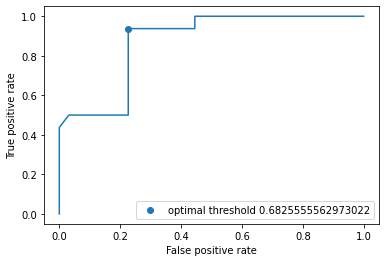

In [25]:
predictions = predict(params_max)
print("Predictions of globally optimised NN:")
for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {predictions[i]}")

fpr, tpr, thresholds = roc_curve(y_true=y[:,0],y_score=predictions, pos_label=1)
metric = jnp.abs(1-tpr) + jnp.abs(fpr)
idx = plt.argmin(metric)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.scatter(fpr[idx], tpr[idx], label=f'optimal threshold {thresholds[idx]}')
plt.legend()
plt.show()

In [26]:
optimal_thresh = thresholds[idx]
classifications = (predictions > optimal_thresh)
accuracy = jnp.mean(classifications == y[:,0])
print(f"accuracy of globally optimised NN with optimal threshold: {accuracy}")

accuracy of globally optimised NN with optimal threshold: 0.8515625


Predictions of BFGS optimised NN:
0: [1. 1. 1. 1. 1. 1. 1. 1.] -> [False] | pred: 3.931084163966641e-23
1: [1. 1. 1. 1. 1. 1. 1. 0.] -> [ True] | pred: 1.0
2: [1. 1. 1. 1. 1. 1. 0. 1.] -> [ True] | pred: 1.0
3: [1. 1. 1. 1. 1. 1. 0. 0.] -> [False] | pred: 0.30311259627342224
4: [1. 1. 1. 1. 1. 0. 1. 1.] -> [ True] | pred: 1.0
5: [1. 1. 1. 1. 1. 0. 1. 0.] -> [False] | pred: 0.30311259627342224
6: [1. 1. 1. 1. 1. 0. 0. 1.] -> [False] | pred: 0.30311259627342224
7: [1. 1. 1. 1. 1. 0. 0. 0.] -> [ True] | pred: 0.30311259627342224
8: [1. 1. 1. 1. 0. 1. 1. 1.] -> [ True] | pred: 0.7724140286445618
9: [1. 1. 1. 1. 0. 1. 1. 0.] -> [False] | pred: 3.794096258964478e-23
10: [1. 1. 1. 1. 0. 1. 0. 1.] -> [False] | pred: 3.794443673307137e-23
11: [1. 1. 1. 1. 0. 1. 0. 0.] -> [ True] | pred: 1.0
12: [1. 1. 1. 1. 0. 0. 1. 1.] -> [False] | pred: 3.794154319127102e-23
13: [1. 1. 1. 1. 0. 0. 1. 0.] -> [ True] | pred: 1.0
14: [1. 1. 1. 1. 0. 0. 0. 1.] -> [ True] | pred: 1.0
15: [1. 1. 1. 1. 0. 0. 0. 0.] 

176: [0. 1. 0. 0. 1. 1. 1. 1.] -> [ True] | pred: 0.772560179233551
177: [0. 1. 0. 0. 1. 1. 1. 0.] -> [False] | pred: 6.470652394944795e-19
178: [0. 1. 0. 0. 1. 1. 0. 1.] -> [False] | pred: 0.0013055158779025078
179: [0. 1. 0. 0. 1. 1. 0. 0.] -> [ True] | pred: 1.0
180: [0. 1. 0. 0. 1. 0. 1. 1.] -> [False] | pred: 1.8992076800117275e-09
181: [0. 1. 0. 0. 1. 0. 1. 0.] -> [ True] | pred: 1.0
182: [0. 1. 0. 0. 1. 0. 0. 1.] -> [ True] | pred: 1.0
183: [0. 1. 0. 0. 1. 0. 0. 0.] -> [False] | pred: 0.30311259627342224
184: [0. 1. 0. 0. 0. 1. 1. 1.] -> [False] | pred: 0.772560179233551
185: [0. 1. 0. 0. 0. 1. 1. 0.] -> [ True] | pred: 0.772560179233551
186: [0. 1. 0. 0. 0. 1. 0. 1.] -> [ True] | pred: 0.772560179233551
187: [0. 1. 0. 0. 0. 1. 0. 0.] -> [False] | pred: 6.944208126762317e-23
188: [0. 1. 0. 0. 0. 0. 1. 1.] -> [ True] | pred: 0.772560179233551
189: [0. 1. 0. 0. 0. 0. 1. 0.] -> [False] | pred: 4.442419700654194e-23
190: [0. 1. 0. 0. 0. 0. 0. 1.] -> [False] | pred: 1.569966689276751

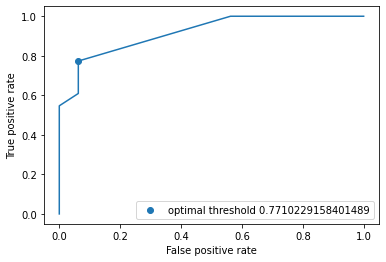

In [27]:
predictions = predict(params_bfgs_max)
print("Predictions of BFGS optimised NN:")
for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {predictions[i]}")

fpr, tpr, thresholds = roc_curve(y_true=y[:,0],y_score=predictions, pos_label=1)
metric = jnp.abs(1-tpr) + jnp.abs(fpr)
idx = plt.argmin(metric)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.scatter(fpr[idx], tpr[idx], label=f'optimal threshold {thresholds[idx]}')
plt.legend()
plt.show()

In [28]:
optimal_thresh = thresholds[idx]
classifications = (predictions > optimal_thresh)
accuracy = jnp.mean(classifications == y[:,0])
print(f"accuracy of BFGS optimised NN with optimal threshold: {accuracy}")

accuracy of BFGS optimised NN with optimal threshold: 0.8515625
